# Proyecto 1

## Adición de ruido.

In [38]:
# Primero importamos los módulos necesarios

import skimage as sk
import numpy as np
import matplotlib.pyplot as plt

# Seguidamente importamos las imágenes

b = sk.io.imread("brain2.jpg", as_gray= True) # Con la funcion io.imread, leemos la imágen que vamos a utilizar
h = sk.io.imread("head.png", as_gray= True)

# Vamos a crear una funcion para representar las imágenes más facilmente
def show(img): 
    sk.io.imshow(img, cmap = 'gray')
    sk.io.show()


In [39]:
#Normalizamos las imágenes

b = b/np.max(b)
h = h/np.max(h)

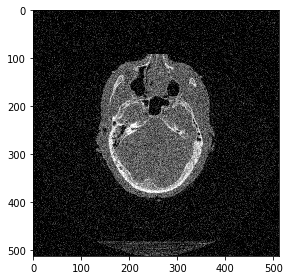

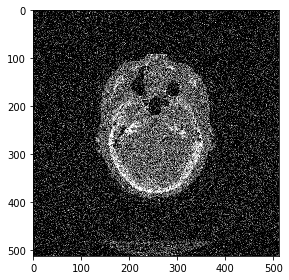

In [40]:
# Antes de utilizar los algoritmos de preprocesado, es necesario añadir ruido a la imagen
# Para ello vamos a usar las funciones de la librería scikit image. 
# Con la funcion random_noise, podemos añadir ruido aleatorio de distintos tipos y con distintas intensidades

ns_h01 = sk.util.random_noise(h, mode='gaussian', var=0.01) # En los ruidos gaussianos podemos modificar la intensidad del ruido mediante el parametro var
ns_h05 = sk.util.random_noise(h, mode='gaussian', var=0.05)

show(ns_h01)
show(ns_h05)

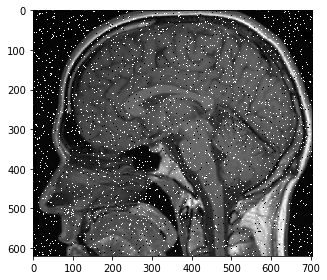

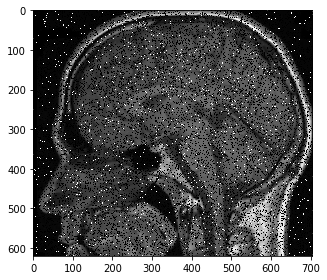

In [41]:
ns_b05 = sk.util.random_noise(b, mode='s&p', amount = 0.05, salt_vs_pepper = 0.75) 
# En los ruidos gaussianos podemos modificar la intensidad del ruido mediante el parametro amount
# También podemos modificar la proporción de puntos blancos y negros mediante el parámetro salt_vs_pepper
ns_b20 = sk.util.random_noise(b, mode='s&p', amount = 0.2, salt_vs_pepper = 0.10)

show(ns_b05)
show(ns_b20)


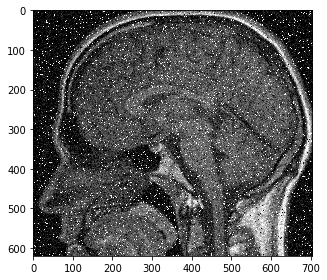

In [42]:
# Vamos a crear una imagen que combine ruido s&p y ruido gaussiano

# Creamos nuestra imagen (mixed) con ruido s&p
ns_mix = sk.util.random_noise(b, mode='s&p', amount = 0.05, salt_vs_pepper = 0.75) 
# Añadimos el ruido gaussiano
ns_mix = sk.util.random_noise(ns_mix, mode='gaussian', var=0.01)

show(ns_mix)

# Filtrado Non Local Means

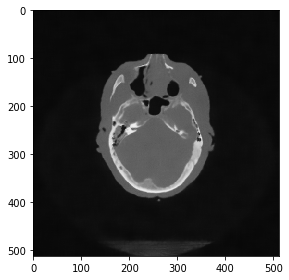

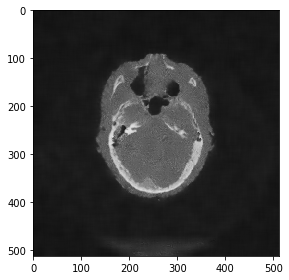

In [53]:
# Vamos a emplear la función denoise_nl_means de la libreria scikit image

# Podemos observar que las caracteristicas por defecto van bien con el ruido gaussiano de intensidad baja
cl_h01 = sk.restoration.denoise_nl_means(ns_h01)

# Sin embargo, no podemos decir que funcione igual de bien con el ruido de alta intensidad
# En este caso, vamos a cambiar el valor de sigma a 0.2, lo que provoca que la imagen sufra un suavizado que es capaz de eliminar el 
# ruido que se encuentra dentro del craneo
cl_h05 = sk.restoration.denoise_nl_means(ns_h05, patch_size = 7, patch_distance= 11, sigma = 0.2, h = 0.1)

show(cl_h01)
show(cl_h05)

Imagen filtrada con NLM (ruido s&p de baja intensidad)


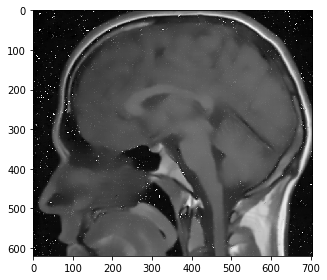

Imagen filtrada con NLM (ruido s&p de alta intensidad


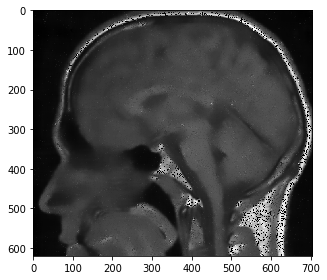

In [45]:
# Realizamos el filtrado de las imagenes con ruido s&p

cl_b05 = sk.restoration.denoise_nl_means(ns_b05, h = 0.11, patch_size=11, patch_distance=15)
cl_b20 = sk.restoration.denoise_nl_means(ns_b20, h = 0.12, patch_size = 11, patch_distance = 15)

print("Imagen filtrada con NLM (ruido s&p de baja intensidad)")
show(cl_b05)
print("Imagen filtrada con NLM (ruido s&p de alta intensidad)")
show(cl_b20)

# Podemos observar que el ruido en ambas imagenes ha disminuido bastante, pero a costa de perder resolucion en los bordes
# También podemos observar que el cuando la proporcion de puntos negros es mayor a la de puntos blancos, la imagen se ve mejor 
# debido a que la mayor parte del fondo es negro

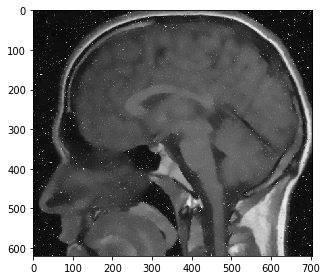

In [46]:
# Vamos a filtrar la imagen con ruido de ambos tipos
# De la misma forma que con la imagen anterior, aumentamos el valor de h para suavizar la imagen

cl_mix = sk.restoration.denoise_nl_means(ns_mix, h=0.12)

show(cl_mix)

# Podemos observar el mismo problema que teníamos con las imagenes con ruido s&p

# Filtrado Anisiotrópico: Perona y Malik

Imagen ruido gaussiano


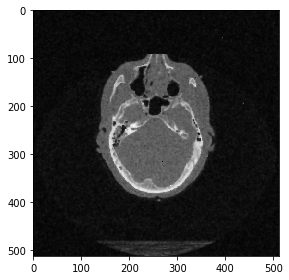

Imagen ruido s&p


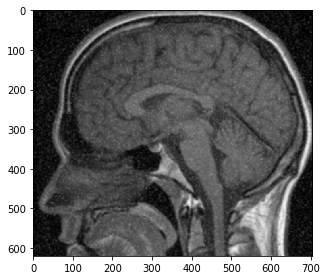

Imagen mixta


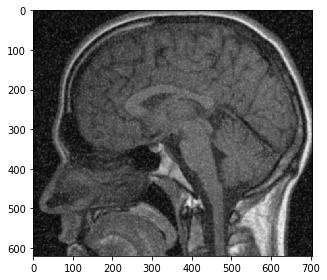

In [47]:
import scipy.ndimage.filters as flt

def anisodiff(img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),sigma=0, option=1):

    # Kappa controla la conducción. Si kappa es pequeña, el filtrado de ruido será más agresivo por lo que se suavizarán más los bordes y se destacarán menos
    # Para una kappa grande, el filtrado será menos agresivo, y los bordes se verán más destacados

    # Delta controla la velocidad de difusión, una delta pequeña aumenta la sensibilidad de la función de difusión, por lo que la difusión será más fuerte y actuará a 
    # un nivel más pequeño, lo que provoca que se dejen pasar detalles finos en la imagen filtrada (como ruido o bordes más finos). Por el contrario, 
    # una delta grande, provocará pasos una difusión más sensible y a una escala mayor, esto dará lugar a una imagen sin tantos detalles.

    # Opción 1 resalta los bordes con alto contraste sobre los que tienen bajo contraste
    # Opción 2 resalta las zonas con bajo contraste

    # Creamos el array de salida
    img = img.astype('float32')
    imgout = img.copy()

    # Creamos variables
    deltaS = np.zeros_like(imgout)
    deltaE = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    gS = np.ones_like(imgout)
    gE = gS.copy()

    for ii in np.arange(1,niter):

        # Calculamos los gradientes
        deltaS[:-1,: ] = np.diff(imgout,axis=0)
        deltaE[: ,:-1] = np.diff(imgout,axis=1)

        if 0<sigma:
            deltaSf=flt.gaussian_filter(deltaS,sigma);
            deltaEf=flt.gaussian_filter(deltaE,sigma);
        else: 
            deltaSf=deltaS;
            deltaEf=deltaE;
            
        # Gradientes de conducción
        if option == 1:
            gS = np.exp(-(deltaSf/kappa)**2.)/step[0]
            gE = np.exp(-(deltaEf/kappa)**2.)/step[1]
        elif option == 2:
            gS = 1./(1.+(deltaSf/kappa)**2.)/step[0]
            gE = 1./(1.+(deltaEf/kappa)**2.)/step[1]

        # Matrices actualizadas
        E = gE*deltaE
        S = gS*deltaS

        NS[:] = S
        EW[:] = E
        NS[1:,:] -= S[:-1,:]
        EW[:,1:] -= E[:,:-1]

        # Actualiza la imagen
        imgout += gamma*(NS+EW)


    return imgout

#Elegimos los parámetros idóneos para las imágenes y las filtramos

print('Imagen ruido gaussiano')
p_h01 = anisodiff(ns_h01, niter = 10, kappa = 0.2, gamma = 0.125)
show(p_h01)

# Filtramos la imagen de la cabeza en el plano transversal
print('Imagen ruido s&p')
p_b05 = anisodiff(ns_b05, niter = 10, kappa = 2, gamma = 0.125)
show(p_b05)

# Filtramos la imagen mixta
print('Imagen mixta')
p_mix = anisodiff(ns_mix, niter = 10, kappa = 2, gamma = 0.125)
show(p_mix)

## Imágenes filtradas utilizando el filtro bilateral

Imagen cabeza plano sagital (gaussian)


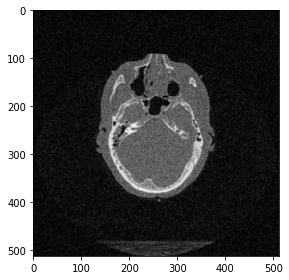

Imagen cabeza plano transversal (s&p)


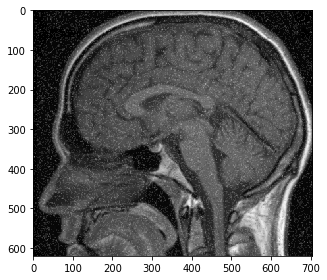

Imagen mixta


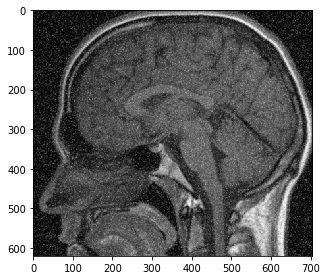

In [48]:
# Filtramos la imagen de la cabeza en el plano sagital
bi_h01 = sk.restoration.denoise_bilateral(ns_h01, win_size=3, sigma_spatial=10, bins=1, cval=0, mode = "constant")

# Filtramos la imagen de la cabeza en el plano transversal
bi_b05 = sk.restoration.denoise_bilateral(ns_b05, win_size=3, sigma_spatial=10, bins=1, cval=0, mode = "constant")

# Filtramos la imagen mixta
bi_mix = sk.restoration.denoise_bilateral(ns_mix, win_size=3, sigma_spatial=10, bins=1, cval=0, mode = "constant")

print("Imagen cabeza plano sagital (gaussian)")
show(bi_h01)

print("Imagen cabeza plano transversal (s&p)")
show(bi_b05)

print("Imagen mixta")
show(bi_mix)

## Imágenes filtradas utilizando los filtros de suavizado estandar

c:\Users\danie\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


Imagen cabeza plano sagital (gaussian)


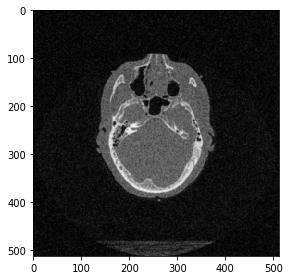

Imagen cabeza plano transversal (s&p)


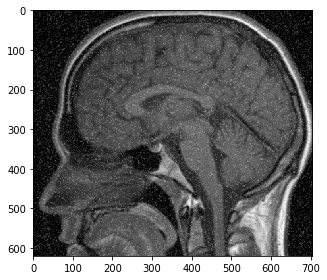

Imagen mixta


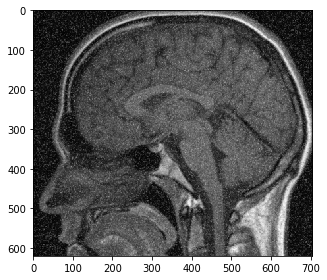

In [49]:
#### FILTRO MEDIA ####

# Creamos un array 3x3 lleno de 1, ese será nuestro footprint. Si tuviesemos un footprint de mayores dimensiones podríamos emborronar los bordes

fp = np.array([[1, 1, 1],
            [1, 1, 1],
            [1, 1, 1]])

# Filtramos la imagen de la cabeza en el plano sagital
mean_h01 = sk.filters.rank.mean(ns_h01, footprint=fp)

# Filtramos la imagen de la cabeza en el plano transversal
mean_b05 = sk.filters.rank.mean(ns_b05, footprint=fp) 

# Filtramos la imagen mixta
mean_mix = sk.filters.rank.mean(ns_mix, footprint=fp)

print("Imagen cabeza plano sagital (gaussian)")
show(mean_h01) 
print("Imagen cabeza plano transversal (s&p)")
show(mean_b05) 
print("Imagen mixta")
show(mean_mix)

Imagen de la cabeza en el plano transversal (gaussian)


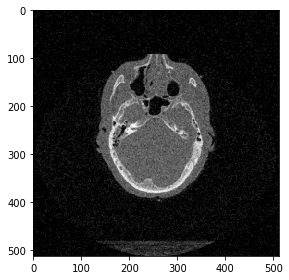

Imagen de la cabeza en el plano sagital (s&p)


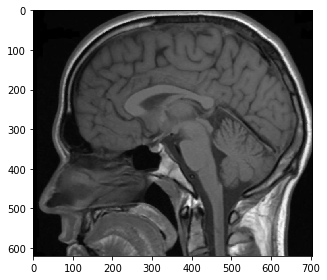

Imagen mixta


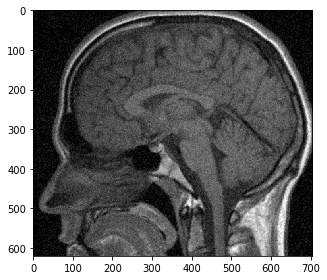

In [50]:
####  FILTRO MEDIANA  #####

# Filtramos la imagen de la cabeza en el plano sagital con una intensidad baja (gaussian)
median_h01 = sk.filters.median(ns_h01)

# Filtramos la imagen de la cabeza en el plano transversal con una intensidad baja (s&p)
median_b05 = sk.filters.median(ns_b05)

# Filtramos la imagen mixta
median_mix = sk.filters.median(ns_mix)

print("Imagen de la cabeza en el plano transversal (gaussian)")
show(median_h01) 
print("Imagen de la cabeza en el plano sagital (s&p)")
show(median_b05) 
print("Imagen mixta")
show(median_mix)

## Extra: utilización de dos filtros

Imagen original


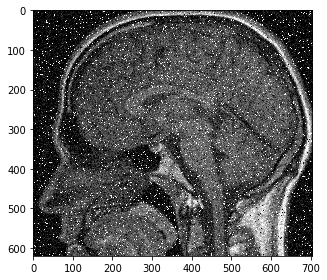

Imagen mixta filtrada con filtro de mediana


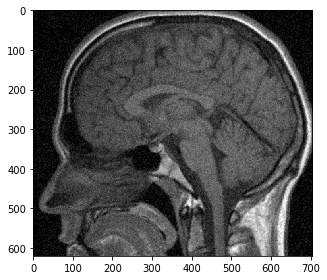

Imagen filtrada con Perona y Malik


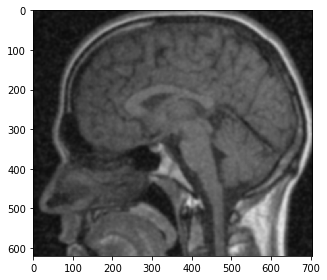

Imagen mixta filtrada con filtro de mediana y filtro Perona y Malik


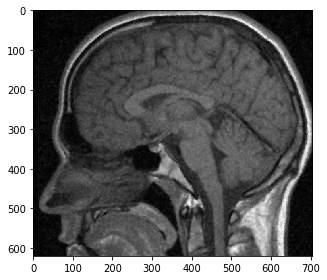

In [74]:
#### FILTRO MEDIANA + FILTRO PERONA Y MALIK ####

print("Imagen original")
show(ns_mix)

prueba_mix = sk.filters.median(ns_mix) # Filtramos la imagen mixta con el filtro de mediana para eliminar todo el ruido s&p que podamos
print("Imagen mixta filtrada con filtro de mediana")
show(prueba_mix)

filtro_pym = anisodiff(ns_mix, niter = 40, kappa = 5, gamma = 0.125) # Filtramos la imagen solo con el filtro de Perona y Malik
print("Imagen filtrada con Perona y Malik")
show(filtro_pym)

filtro_pym_mediana = anisodiff(prueba_mix, niter = 10, kappa = 0.1, gamma = 0.125) # Filtramos la imagen ya filtrada con el filtro Perona y Malik
print("Imagen mixta filtrada con filtro de mediana y filtro Perona y Malik")
show(filtro_pym_mediana)


Imagen con ruido


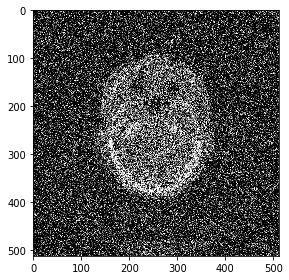

Imagen filtrada con filtro de mediana


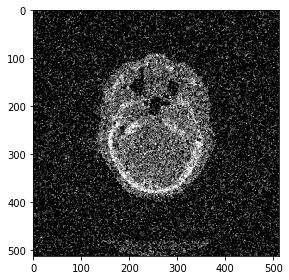

Imagen filtrada con filtro NLM


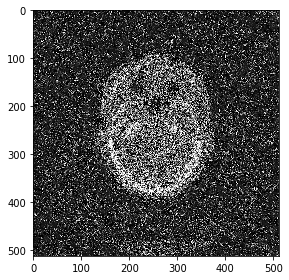

Imagen filtrada con filtro NLM y filtro de mediana


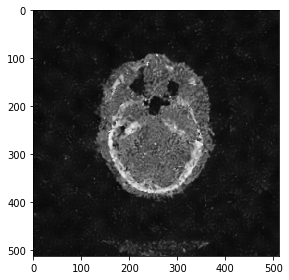

In [69]:
#### FILTRO DE MEDIANA Y NLM ####
# Vamos a realizar otro ejemplo utilzando el filtro de mediana y el filtro NLM
# Creamos una imagen de la cabeza (plano sagital) con mucho ruido gaussiano

prueba_gaus = sk.util.random_noise(h, mode='gaussian', var=0.2)
print("Imagen con ruido")
show(prueba_gaus)

# Ahora filtramos la imagen con el filtro de mediana
filtro_mediana = sk.filters.median(prueba_gaus)
print("Imagen filtrada con filtro de mediana")
show(filtro_mediana)

# Filtramos la imagen solo con el filtro NLM
filtro_nlm = sk.restoration.denoise_nl_means(prueba_gaus, sigma = 0.1)
print("Imagen filtrada con filtro NLM")
show(filtro_nlm)

# Por último, filtramos la imagen con el filtro NLM
filtro_nlm_mediana = sk.restoration.denoise_nl_means(filtro_mediana, sigma = 0.1)
print("Imagen filtrada con filtro NLM y filtro de mediana")
show(filtro_nlm_mediana)

# Como se puede observar, el empleo de varios filtros puede ayudar a reducir el ruido (aunque sea levemente)